In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

[d6-w6420b-23:2912844] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.d6-w6420b-23.614072/jf.0/1432289280/shared_mem_cuda_pool.d6-w6420b-23 could be created.
[d6-w6420b-23:2912844] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
/home/jcolen/envs/pbnn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 256/256 [00:00<00:00, 8876.61it/s]


063: Reduced functional loss: 8.56e-17
066: Reduced functional loss: 2.53e-16
122: Reduced functional loss: 5.94e-16


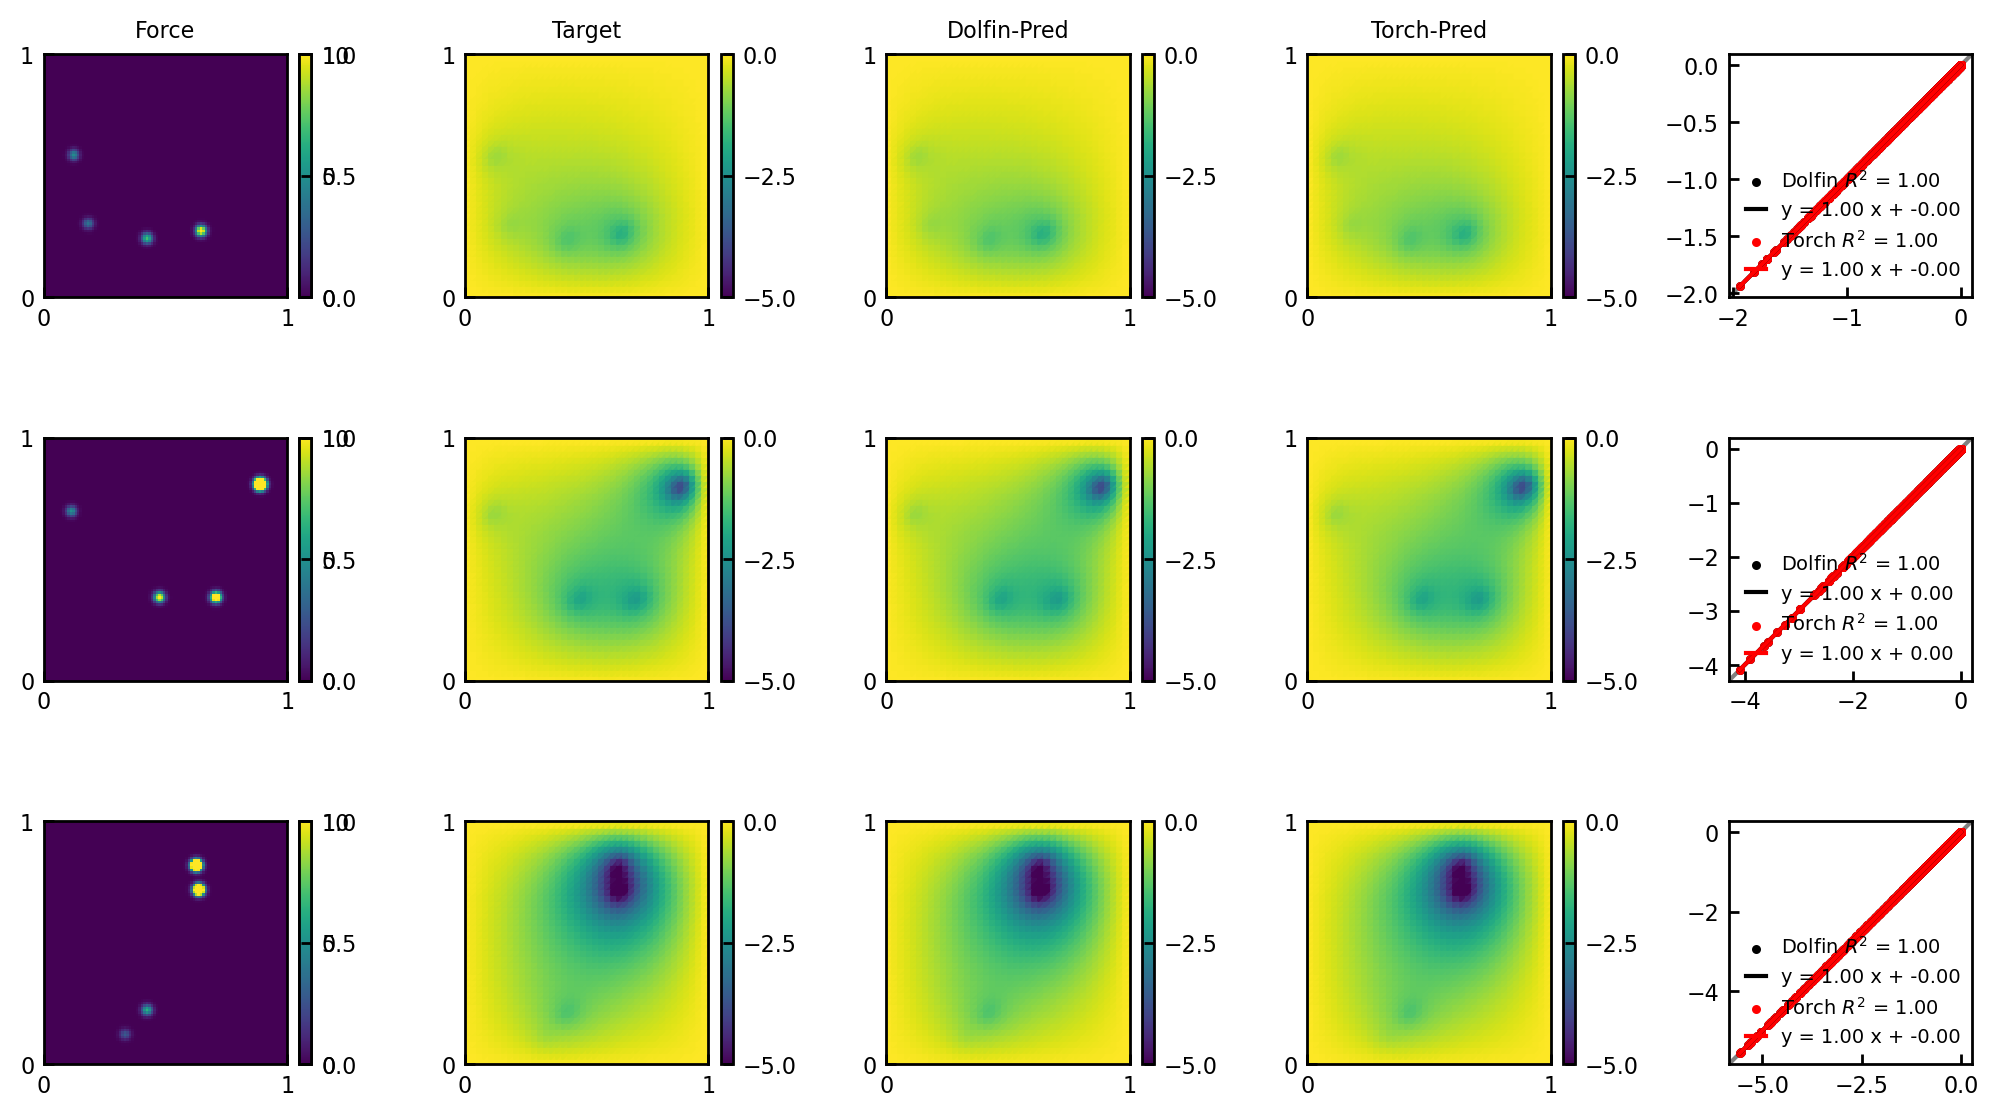

In [2]:
# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
import dolfin_adjoint as d_ad
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *

from data_processing import HDF5Dataset

dataset = HDF5Dataset(
    path='../data/poisson_dataset.hdf5', 
    mesh='../data/square_mesh.xml', 
    build_problem='dolfin_problems.BuildPoissonProblem'
)


fig, ax = plt.subplots(3, 5, figsize=(10, 6))

for i in range(ax.shape[0]):
    d_ad.set_working_tape(d_ad.Tape())

    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    inputs = sample['inputs']
    force = sample['force']
    output = sample['output']
    function_space = sample['function_space']
    v2d = dlf.vertex_to_dof_map(function_space)

    plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1])
    plot_grid(ax[i,0], force[0], inputs[0], inputs[1], vmin=0, vmax=10)

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], function_space, return_function=True)
    dolfin_pred = dataset.build_problem.forward(force_mesh)
    dolfin_pred = dolfin_pred.vector()[v2d]

    rhs, _ = dataset.build_problem.assemble_problem(output)
    torch_pred = np.einsum('ij,j->i', rhs, force_mesh.vector()[:])
    torch_pred = torch_pred[v2d]

    plot_mesh(ax[i,1], output, dataset.mesh, vmin=-5, vmax=0)
    plot_mesh(ax[i,2], dolfin_pred, dataset.mesh, vmin=-5, vmax=0)
    plot_mesh(ax[i,3], torch_pred, dataset.mesh, vmin=-5, vmax=0)
    plot_with_regression(ax[i,4], output, dolfin_pred, label='Dolfin', color='black')
    plot_with_regression(ax[i,4], output, torch_pred, label='Torch', color='red')

    Jhat = sample['Jhat']
    print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax[:, :4].flatten():
    a.set(xlim=[0,1], ylim=[0,1], xticks=[0,1], yticks=[0,1], aspect='equal')

for a in ax[:, 4]:
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
    a.set(xlim=xlim, ylim=xlim, aspect='equal')
    a.legend()

ax[0,0].set_title('Force')
ax[0,1].set_title('Target')
ax[0,2].set_title('Dolfin-Pred')
ax[0,3].set_title('Torch-Pred')

plt.tight_layout()

100%|██████████| 256/256 [00:00<00:00, 8618.06it/s]


207: Reduced functional loss: 2.58e-06
252: Reduced functional loss: 2.19e-06
107: Reduced functional loss: 8.65e-06


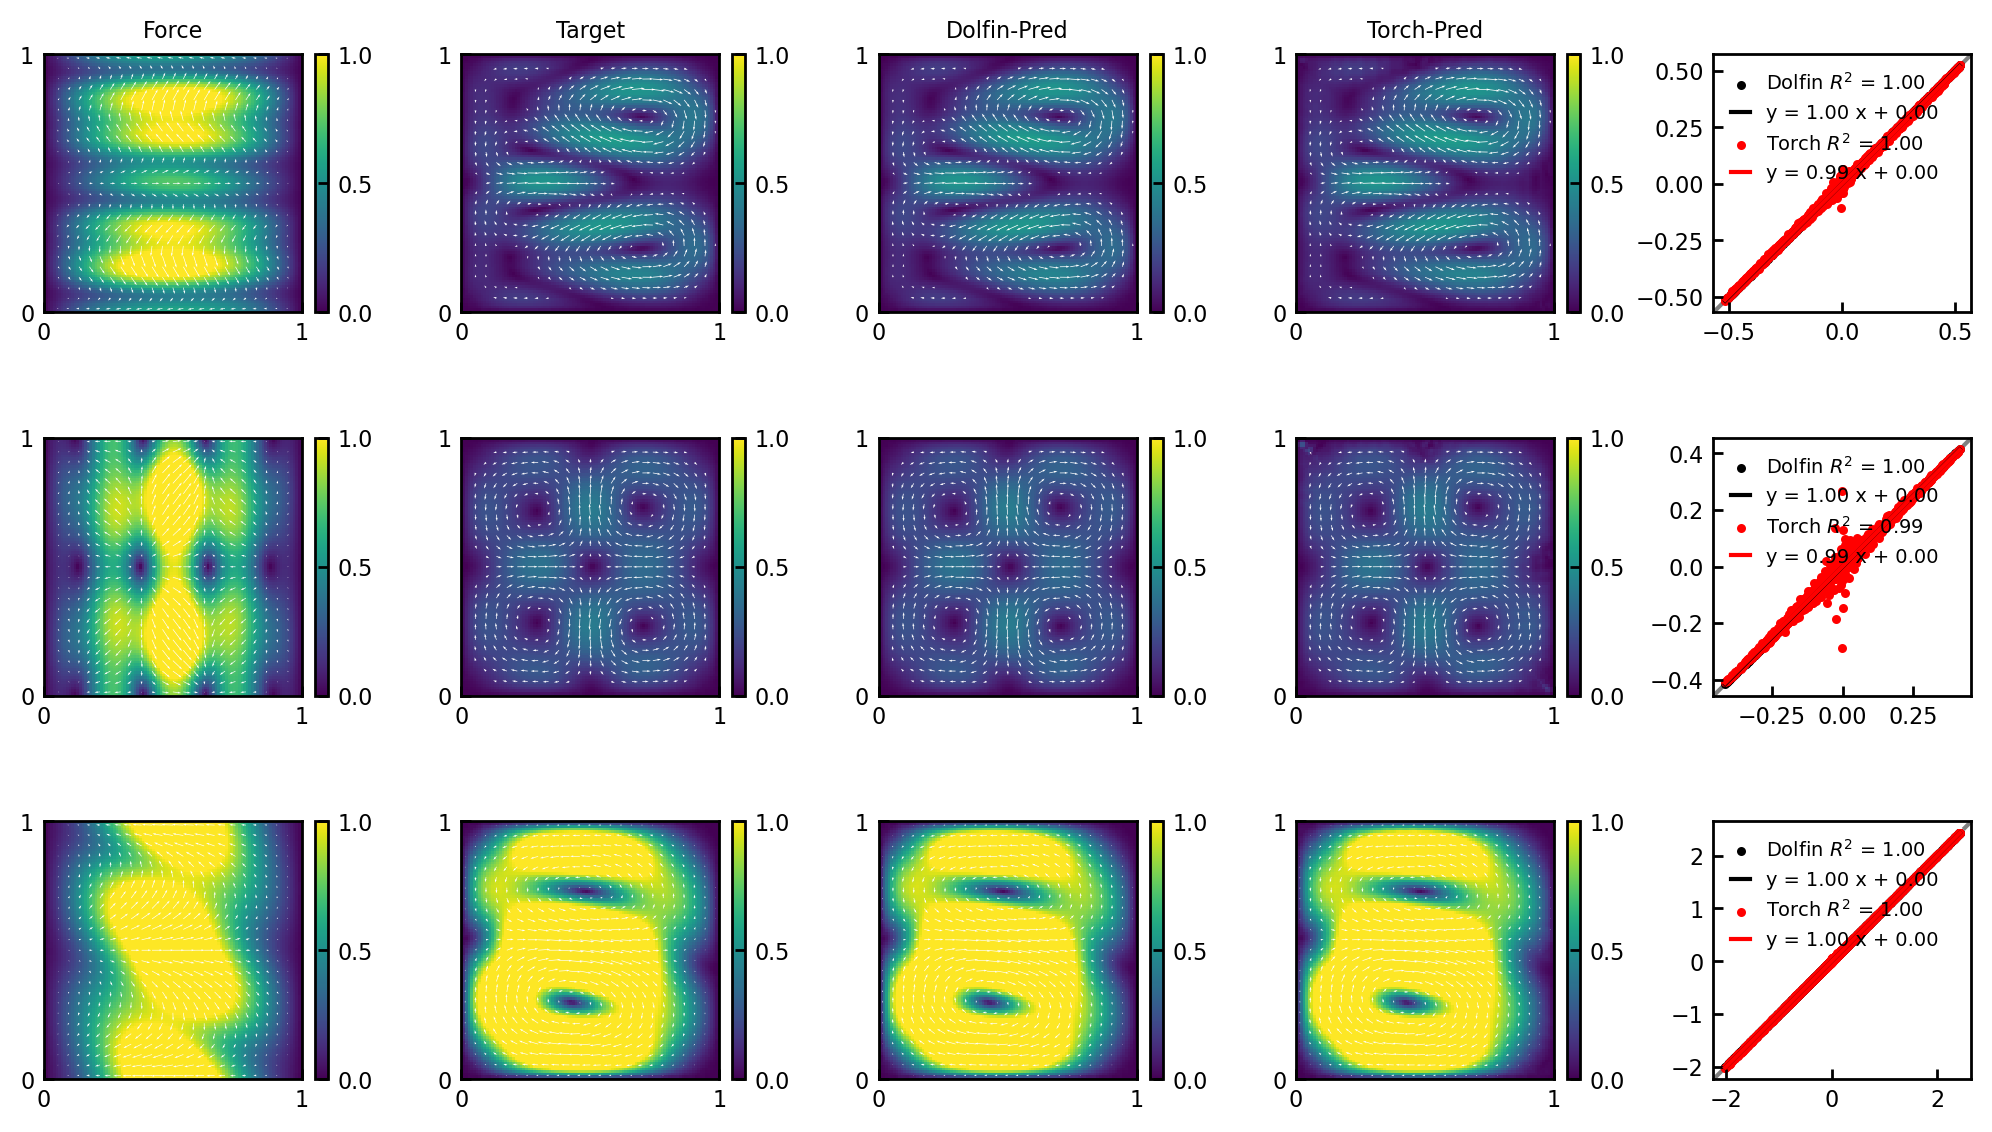

In [3]:
# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
import dolfin_adjoint as d_ad
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *

from data_processing import HDF5Dataset

dataset = HDF5Dataset(
    path='../data/stokes_dataset.hdf5', 
    mesh='../data/square_mesh.xml', 
    build_problem='dolfin_problems.BuildStokesProblem'
)

num_rows = 3
fig, ax = plt.subplots(num_rows, 5, figsize=(10, 2 * num_rows), squeeze=False)

for i in range(num_rows):
    d_ad.set_working_tape(d_ad.Tape())

    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    inputs = sample['inputs']
    force = sample['force']
    output = sample['output']
    function_space = sample['function_space']
    v2d = dlf.vertex_to_dof_map(function_space)

    plot_grid_vector(ax[i,0], force, inputs[0], inputs[1], vmin=0, vmax=1)
    plot_mesh_vector(ax[i,1], output, dataset.mesh, vmin=0, vmax=1)

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], function_space, return_function=True)
    dolfin_pred = dataset.build_problem.forward(force_mesh)
    dolfin_pred = dolfin_pred.compute_vertex_values().reshape([2, -1])
    plot_mesh_vector(ax[i,2], dolfin_pred, dataset.mesh, vmin=0, vmax=1)
    plot_with_regression(ax[i,4], output.flatten(), dolfin_pred.flatten(), label='Dolfin', color='black')

    rhs, _ = dataset.build_problem.assemble_problem(output)
    torch_pred = np.einsum('ij,j->i', rhs, force_mesh.vector()[:])
    torch_pred = torch_pred[v2d].reshape([-1, 2]).T

    plot_mesh_vector(ax[i,3], torch_pred, dataset.mesh, vmin=0, vmax=1)
    plot_with_regression(ax[i,4], output.flatten(), torch_pred.flatten(), label='Torch', color='red')

    Jhat = sample['Jhat']
    print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax[:, :4].flatten():
    a.set(xlim=[0,1], ylim=[0,1], xticks=[0,1], yticks=[0,1], aspect='equal')

for a in ax[:, 4]:
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
    a.set(xlim=xlim, ylim=xlim, aspect='equal')
    a.legend()

ax[0,0].set_title('Force')
ax[0,1].set_title('Target')
ax[0,2].set_title('Dolfin-Pred')
ax[0,3].set_title('Torch-Pred')

plt.tight_layout()

100%|██████████| 256/256 [00:00<00:00, 9073.90it/s]


232: Reduced functional loss: 7.28e-06
163: Reduced functional loss: 8.52e-06
005: Reduced functional loss: 6.76e-06


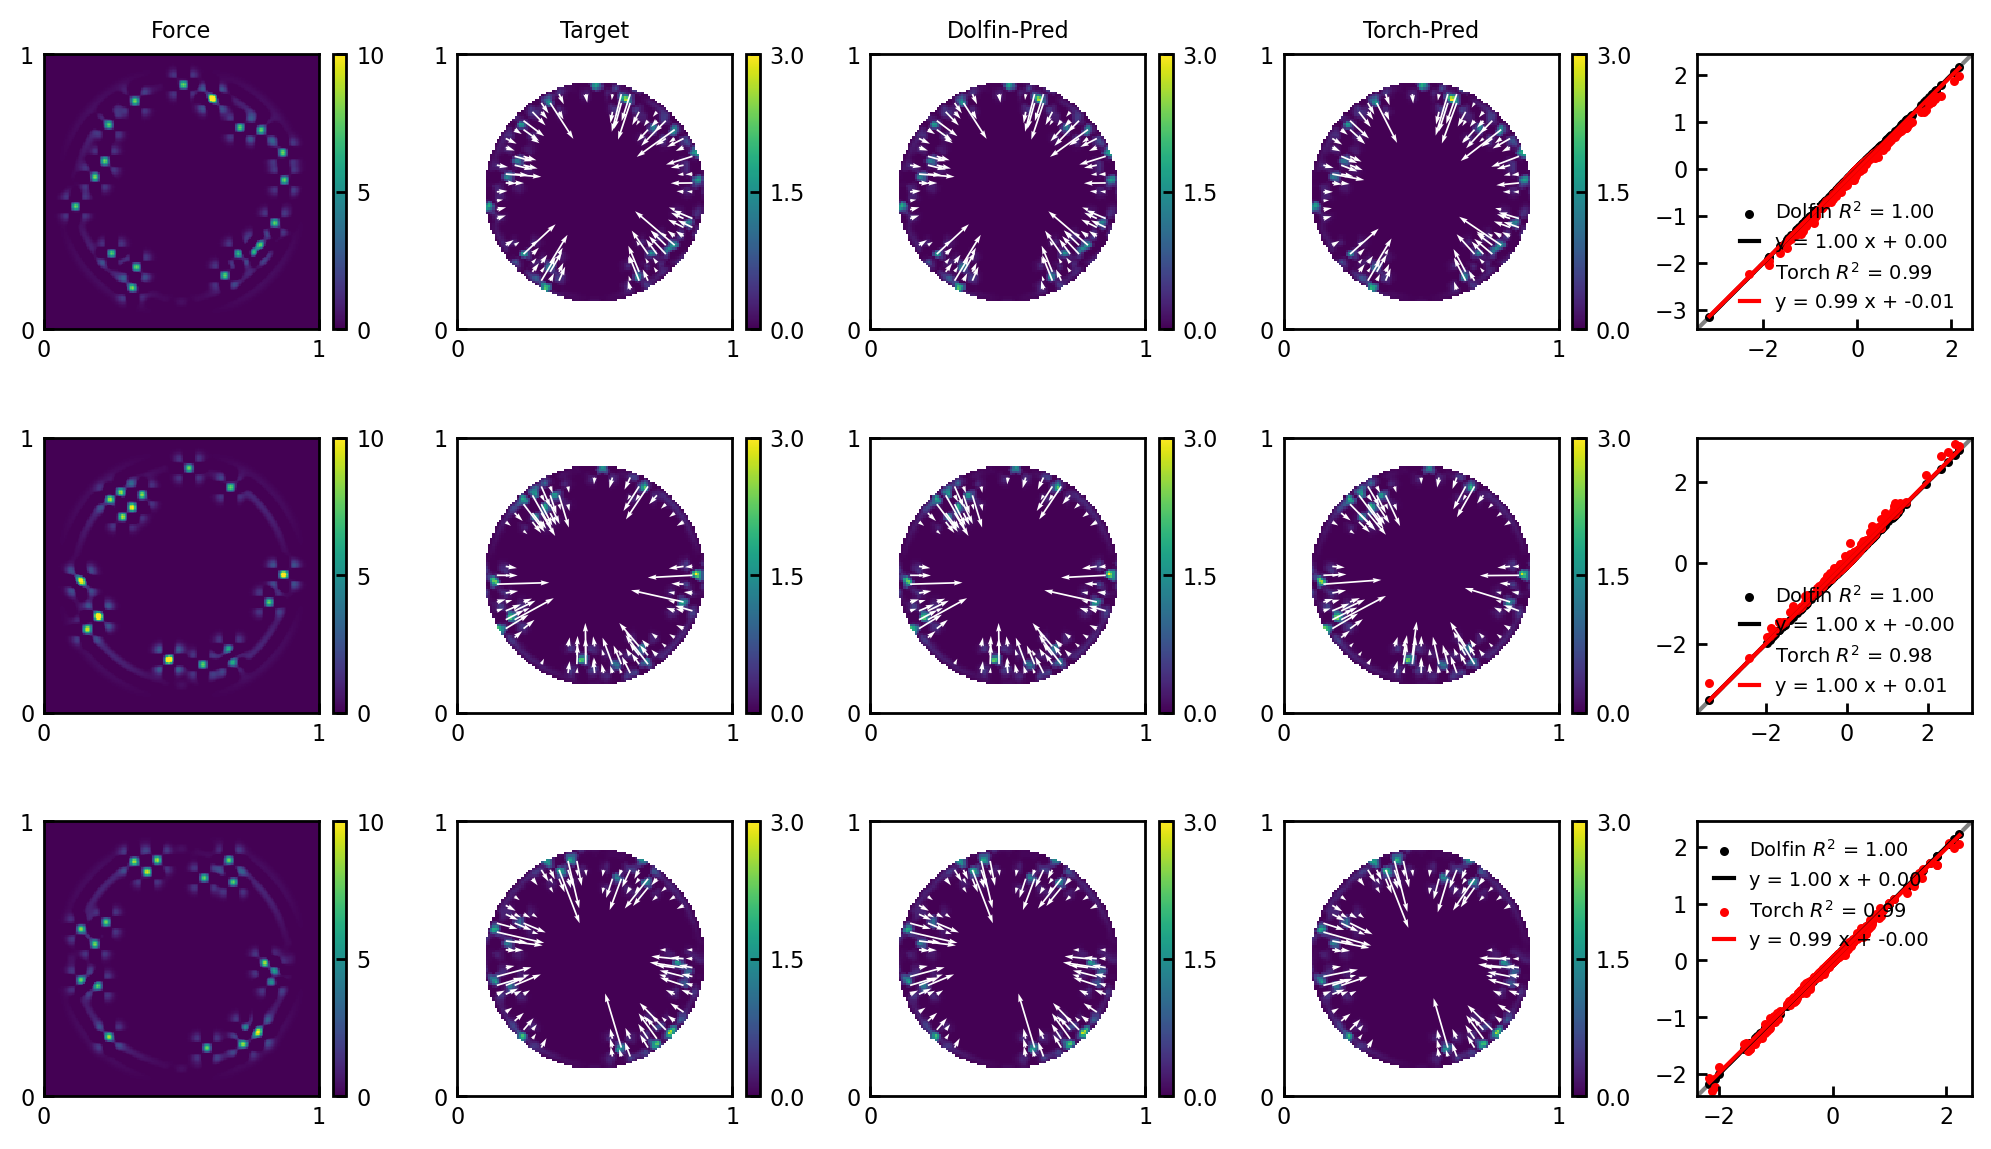

In [6]:
# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
import dolfin_adjoint as d_ad
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *

from data_processing import HDF5Dataset

dataset = HDF5Dataset(
    path='../data/elasticity_adhesion_dataset.hdf5', 
    mesh='../data/circle_mesh.xml', 
    build_problem='dolfin_problems.BuildElasticityAdhesionProblem'
)

num_rows = 3
fig, ax = plt.subplots(num_rows, 5, figsize=(10, 2 * num_rows), squeeze=False)

for i in range(num_rows):
    d_ad.set_working_tape(d_ad.Tape())

    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    inputs = sample['inputs']
    force = sample['force']
    output = sample['output']
    function_space = sample['function_space']
    v2d = dlf.vertex_to_dof_map(function_space)

    plot_grid(ax[i,0], force[0], inputs[0], inputs[1], vmin=0, vmax=10)
    plot_mesh_vector(ax[i,1], output, dataset.mesh, vmin=0, vmax=3)

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], function_space, return_function=True)
    dolfin_pred = dataset.build_problem.forward(force_mesh)
    dolfin_pred = dolfin_pred.compute_vertex_values().reshape([2, -1]) * force_mesh.compute_vertex_values()
    plot_mesh_vector(ax[i,2], dolfin_pred, dataset.mesh, vmin=0, vmax=3)
    plot_with_regression(ax[i,4], output.flatten(), dolfin_pred.flatten(), label='Dolfin', color='black')

    """ We CAN dynamically set the Y field and get the solution, but this implementation won't really 
        work with torch. In a nutshell, we have an issue because the cell adhesion problem is singular.
        We could do an iterative solution but that still requires a least squares solution technique 
        for large sparse matrices. Unfortunately, torch doesn't have that, and implementing it
        is above my pay grade.

        For the future -- could consider *NOT* solving the linear problem directly. Instead, 
        Simply define the loss as the squared residual (A u_{target} - L)^2 
    """
    Y = np.repeat(force_mesh.vector()[:][:, None], 2, axis=1).flatten()
    Y = sparse.diags(Y)

    solution_matrix, _ = dataset.build_problem.assemble_problem(output)
    A1, A2, B = solution_matrix
    A = A1 + A2 @ Y

    torch_pred = sparse.linalg.lsqr(A1 + A2, B)[0]

    # TODO: Make this work with the torch pipeline as well
    # rhs, _ = dataset.build_problem.assemble_problem(output)
    # torch_pred = np.einsum('ij,j->i', rhs, force_mesh.vector()[:])

    v2d = dlf.vertex_to_dof_map(dataset.build_problem.vector_function_space)
    torch_pred = torch_pred[v2d].reshape([-1, 2]).T
    torch_pred = torch_pred * force_mesh.compute_vertex_values()

    plot_mesh_vector(ax[i,3], torch_pred, dataset.mesh, vmin=0, vmax=3)
    plot_with_regression(ax[i,4], output.flatten(), torch_pred.flatten(), label='Torch', color='red')

    Jhat = sample['Jhat']
    print(f'{idx:03d}: Reduced functional loss: {Jhat(force_mesh.vector()[:]):.3g}')

for a in ax[:, :4].flatten():
    a.set(xlim=[0,1], ylim=[0,1], xticks=[0,1], yticks=[0,1], aspect='equal')

for a in ax[:, 4]:
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
    a.set(xlim=xlim, ylim=xlim, aspect='equal')
    a.legend()

ax[0,0].set_title('Force')
ax[0,1].set_title('Target')
ax[0,2].set_title('Dolfin-Pred')
ax[0,3].set_title('Torch-Pred')

plt.tight_layout()